# Import Libraries and Load Data

In [2]:
!pip install pandas_profiling==2.7.1

  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 1.4.1
    Uninstalling pandas-profiling-1.4.1:
      Successfully uninstalled pandas-profiling-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
raw_data_2016 = pd.read_csv('drive/MyDrive/datasets/DS salary/2016/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv')

In [5]:
raw_data_2016.head(5)

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,occupation_group,experience_range,experience_midpoint,salary_range,salary_midpoint,big_mac_index,tech_do,tech_want,aliens,programming_ability,employment_status,industry,company_size_range,team_size_range,women_on_team,remote,job_satisfaction,job_discovery,dev_environment,commit_frequency,hobby,dogs_vs_cats,desktop_os,unit_testing,rep_range,visit_frequency,why_learn_new_tech,education,open_to_new_job,new_job_value,job_search_annoyance,interview_likelihood,how_to_improve_interview_process,star_wars_vs_star_trek,agree_tech,agree_notice,agree_problemsolving,agree_diversity,agree_adblocker,agree_alcohol,agree_loveboss,agree_nightcode,agree_legacy,agree_mars,important_variety,important_control,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,"Mobile Dev (Android, iOS, WP & Multi-Platform)",6 - 10 years,8.0,"$40,000 - $50,000",45000.0,NaN,iOS; Objective-C,Swift,Yes,7.0,Employed full-time,Consulting,100-499 employees,15-20 people,3,I rarely work remotely,I love my job,I knew I wanted to work here. I sought out the...,TextMate; Xcode,Multiple times a day,1-2 hours per week,Cats,Mac OS X,No,1,Multiple times a day,To keep my skills up to date,I'm self-taught; On-the-job training; B.S. in ...,I am not interested in new job opportunities,Salary; Ability to make or influence important...,Taking time off work to interview,10%,Show me more live code; Introduce me to the te...,Star Wars,Agree completely,Agree completely,Agree completely,Agree somewhat,Agree completely,Neutral,Agree somewhat,Neutral,Agree somewhat,Disagree somewhat,This is very important,This is very important,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,11164,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21378,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,Female,Engineer,DevOps,DevOps,11+ years,13.0,"Less than $10,000",5000.0,NaN,NaN,NaN,Other (please specify),8.0,Freelance / Contractor,Finance / Banking,100-499 employees,1-4 people,2,Part-time remote,I love my job,Other,Visual Studio,Multiple times a day,2-5 hours per week,Cats,Other Linux,Yes,I'm not sure,Once a week,NaN,I'm self-taught; On-the-job training,"I'm not actively looking, but I am open to new...",Office location; Remote working option; Flexib...,Other (please specify),0%,Be more flexible about interview scheduling; O...,NaN,Agree completely,Neutral,Agree somewhat,Agree somewhat,Agree completely,Disagree completely,Disagree completely,Agree completely,Agree somewhat,Disagree completely,This is somewhat important,I don't care about this,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn


# Exploring Data

In [ ]:
raw_data_2016.columns

Index(['Unnamed: 0', 'collector', 'country', 'un_subregion', 'so_region',
       'age_range', 'age_midpoint', 'gender', 'self_identification',
       'occupation', 'occupation_group', 'experience_range',
       'experience_midpoint', 'salary_range', 'salary_midpoint',
       'big_mac_index', 'tech_do', 'tech_want', 'aliens',
       'programming_ability', 'employment_status', 'industry',
       'company_size_range', 'team_size_range', 'women_on_team', 'remote',
       'job_satisfaction', 'job_discovery', 'dev_environment',
       'commit_frequency', 'hobby', 'dogs_vs_cats', 'desktop_os',
       'unit_testing', 'rep_range', 'visit_frequency', 'why_learn_new_tech',
       'education', 'open_to_new_job', 'new_job_value', 'job_search_annoyance',
       'interview_likelihood', 'how_to_improve_interview_process',
       'star_wars_vs_star_trek', 'agree_tech', 'agree_notice',
       'agree_problemsolving', 'agree_diversity', 'agree_adblocker',
       'agree_alcohol', 'agree_loveboss', 'agree_n

In [ ]:
# pandas_profiling.ProfileReport(raw_data_2016)

# Data Cleaning

## Removing irrelvelant features 1

'employment_status', 'remote', 'job_discovery', 'gender'

In [ ]:
all_features = raw_data_2016.columns
useful_features = ['country', 'age_midpoint', 'experience_midpoint', 'salary_midpoint', 'programming_ability', 'remote',
                   'occupation_group', 'company_size_range', 'employment_status', 'gender', 'job_satisfaction', 'industry',
                   'important_promotion', 'important_companymission', 'education',
                   'job_discovery', 'hobby', 'open_to_new_job', 'agree_loveboss']
irrelevant_features = np.setdiff1d(all_features, useful_features)

print(len(all_features), len(useful_features), len(irrelevant_features))

66 19 47


In [ ]:
data_2016 = raw_data_2016.drop(irrelevant_features, axis = 1)
data_2016 = data_2016.dropna()
for feature in useful_features:
    data_2016 = data_2016.drop(data_2016[data_2016[feature] == 'Other (please specify)'].index, axis = 0)
print(data_2016.shape)
print(data_2016.columns)

(24647, 19)
Index(['country', 'age_midpoint', 'gender', 'occupation_group',
       'experience_midpoint', 'salary_midpoint', 'programming_ability',
       'employment_status', 'industry', 'company_size_range', 'remote',
       'job_satisfaction', 'job_discovery', 'hobby', 'education',
       'open_to_new_job', 'agree_loveboss', 'important_promotion',
       'important_companymission'],
      dtype='object')


## Country

In [ ]:
# Country

from geopy.geocoders import Nominatim
from tqdm import tqdm
geolocator = Nominatim(user_agent = 'my_user_agent')

countries = np.unique(data_2016['country'])
latitudes = []
longitudes = []

for country in tqdm(countries):
    coordinates = geolocator.geocode(country)
    latitudes.append(coordinates.latitude)
    longitudes.append(coordinates.longitude)

 63%|██████▎   | 89/141 [00:44<00:25,  2.02it/s]


KeyboardInterrupt: ignored

In [ ]:
data_2016['latitudes'] = ''
data_2016['longitudes'] = ''
for i in range(len(data_2016)):
    country = data_2016['country'].iloc[i]
    index = np.where(country == countries)[0][0]
    #print(index[0])
    data_2016['latitudes'].iloc[i] = latitudes[index]
    data_2016['longitudes'].iloc[i] = longitudes[index]

## Categorical Features

In [ ]:
all_answers = []
for i in range(len(data_2016)):
    one_answer = data_2016['education'].iloc[i].split("; ")
    for education in one_answer:
        all_answers.append(education)
education_types = list(set(all_answers))

In [ ]:
education_types

In [ ]:
for education in education_types:
    data_2016[education] = ''
    for i in range(len(data_2016)):      
        data_2016[education].iloc[i] = data_2016['education'].iloc[i].count(education)

In [ ]:
# Gender
print(np.unique(data_2016['gender'], return_counts = True))
data_2016 = data_2016.drop(data_2016[data_2016['gender'] == 'Prefer not to disclose'].index, axis = 0)

In [ ]:
# Occupation group
print(np.unique(data_2016['occupation_group'], return_counts = True))
# Student, employee, manger
data_2016['student'] = data_2016['occupation_group'].str.count('Student')
data_2016['executive'] = data_2016['occupation_group'].str.count('Executive')
data_2016['manager'] = data_2016['occupation_group'].str.count('manager')
data_2016['employee'] = 1 - data_2016['student'] - data_2016['executive'] - data_2016['manager']


In [ ]:
print(sum(data_2016['student']), sum(data_2016['executive']), sum(data_2016['manager']), sum(data_2016['employee']))

In [ ]:
# industry

print(np.unique(data_2016['industry'], return_counts = True))
data_2016 = data_2016.drop(data_2016[data_2016['industry'] == "I'm a student"].index, axis = 0)
data_2016 = data_2016.drop(data_2016[data_2016['industry'] == 'Not Currently Employed'].index, axis = 0)

In [ ]:
# company_size_range

print(np.unique(data_2016['company_size_range'], return_counts = True))
data_2016['company_size_range'] = data_2016['company_size_range'].replace('I am not part of a company', 'I am not sure')
data_2016 = data_2016.drop(data_2016[data_2016['company_size_range'] == 'I am not sure'].index, axis = 0)

In [ ]:
# remote
np.unique(data_2016['remote'], return_counts = True)
data_2016['remote'] = data_2016['remote'].replace('I rarely work remotely', 'Never')



```
# job_satisfaction
print(np.unique(data_2016['job_satisfaction']))
data_2016 = data_2016.drop(data_2016[data_2016['job_satisfaction'] == "I don't have a job"].index, axis = 0)
data_2016['job_satisfaction'] = data_2016['job_satisfaction'].replace({'I hate my job': -2,
                                                                       "I'm somewhat dissatisfied with my job": -1,
                                                                       "I'm neither satisfied nor dissatisfied": 0,
                                                                       "I'm somewhat satisfied with my job": 1,
                                                                       'I love my job': 2})
```



In [ ]:
# job_satisfaction
print(np.unique(data_2016['job_satisfaction'], return_counts = True))
data_2016 = data_2016.drop(data_2016[data_2016['job_satisfaction'] == "I don't have a job"].index, axis = 0)
data_2016['job_satisfaction'] = data_2016['job_satisfaction'].replace({'I hate my job': -2,
                                                                       "I'm somewhat dissatisfied with my job": -1,
                                                                       "I'm neither satisfied nor dissatisfied": 0,
                                                                       "I'm somewhat satisfied with my job": 1,
                                                                       'I love my job': 2})

In [ ]:
print(np.unique(data_2016['employment_status'], return_counts = True))
data_2016 = data_2016.drop(data_2016[data_2016['employment_status'] == "Prefer not to disclose"].index, axis = 0)
data_2016 = data_2016.drop(data_2016[data_2016['employment_status'] == 'Unemployed'].index, axis = 0)

In [ ]:
print(np.unique(data_2016['job_discovery'], return_counts = True))
data_2016 = data_2016.drop(data_2016[data_2016['job_discovery'] == "I don't have a job"].index, axis = 0)

In [ ]:
data_2016['exp/age'] = data_2016['experience_midpoint'] / data_2016['age_midpoint']

In [ ]:
data_2016[['latitudes', 'longitudes']] = data_2016[['latitudes', 'longitudes']].astype(float)

In [ ]:
data_2016[education_types] = data_2016[education_types].astype(float)

In [ ]:
cat_features = ['occupation_group', 'company_size_range', 'employment_status', 'gender', 'remote',
                'industry', 'important_promotion', 'important_companymission',
                'job_discovery', 'hobby', 'open_to_new_job', 'agree_loveboss']
data_2016 = pd.get_dummies(data = data_2016, columns = cat_features, prefix = None)

In [ ]:
data_2016.corr().head(50)



```
# save cleaned data
data_2016.to_csv('drive/MyDrive/datasets/DS salary/2016/data_2016.csv', index = False)
```



In [ ]:
pd.read_csv('drive/MyDrive/datasets/DS salary/2016/data_2016.csv')

# Labeling, Splitting and Scaling

In [6]:
# load cleaned data
data_2016 = pd.read_csv('drive/MyDrive/datasets/DS salary/2016/data_2016.csv')

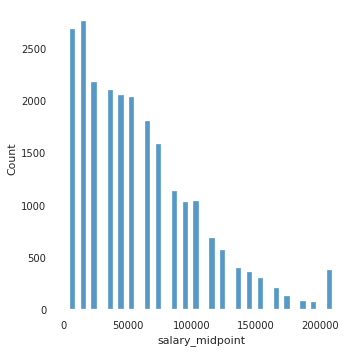

In [7]:
sns.displot(data_2016['salary_midpoint'])

In [8]:
data_2016['salary_label'] = pd.cut(data_2016['salary_midpoint'],
                                   bins = [-1, 15000, 85000, np.inf],
                                   labels = [1, 2, 3])
_, num_labels = np.unique(data_2016['salary_label'], return_counts = True)
num_labels / len(data_2016)

array([0.2309949 , 0.54655612, 0.22244898])

In [9]:
np.unique(data_2016['salary_midpoint'], return_counts = True)[1] / len(data_2016)

array([0.11377551, 0.11721939, 0.09243197, 0.0889881 , 0.08715986,
       0.08609694, 0.07653061, 0.06721939, 0.04812925, 0.04366497,
       0.04417517, 0.02916667, 0.02397959, 0.01696429, 0.01530612,
       0.01267007, 0.00854592, 0.00535714, 0.00331633, 0.00314626,
       0.01615646])

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss1 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.4, random_state = 42)

X_all = np.array(data_2016.drop(['country', 'education', 'salary_midpoint', 'salary_label'], axis = 1))
salary_label = np.array(data_2016['salary_label'])

for train_index, cross_index in sss1.split(X_all, data_2016['salary_label']):
    # print(train_index)
    train_set, label_train_set = X_all[train_index], salary_label[train_index]
    cross_set, label_cross_set = X_all[cross_index], salary_label[cross_index]

sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)

for val_index, test_index in sss2.split(cross_set, label_cross_set):
    val_set, label_val_set = cross_set[val_index], label_cross_set[val_index]
    test_set, label_test_set = cross_set[test_index], label_cross_set[test_index]

# Over sampling and Model Selection

I tried a couple of classifiers, namely KNeighbor, Stochastic Gradient Descent, Random Forest, AdaBoost and Random Forest did the best so I picked this algorithm.

In [11]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()

X_train, X_test = SS.fit_transform(train_set), SS.transform(test_set)
Y_train, Y_test = label_train_set, label_test_set

In [12]:
from imblearn.over_sampling import SMOTE

over_sample = SMOTE(random_state = 42)
X_smote, Y_smote = over_sample.fit_resample(X_train, Y_train)

In [13]:
np.unique(Y_smote, return_counts = True)

(array([1, 2, 3]), array([7713, 7713, 7713]))

In [14]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 80, random_state = 42, n_jobs = -1,
                             max_features = 'auto', max_depth = 50, min_samples_leaf = 6)
RFC.fit(X_smote, Y_smote)

RandomForestClassifier(max_depth=50, min_samples_leaf=6, n_estimators=80,
                       n_jobs=-1, random_state=42)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score

def model_scores(model, x, y):

    y_pred = model.predict(x)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average = None)
    confusing_matrix = confusion_matrix(y, y_pred)
    confusing_matrix = pd.DataFrame(confusing_matrix)
    f1 = f1_score(y, y_pred, average = 'weighted')

    return accuracy, precision, confusing_matrix, f1

In [16]:
train_accuracy, train_precision, confusing_matrix, train_f1 = model_scores(RFC, X_smote, Y_smote)
print(train_accuracy)
print(train_precision)
print(confusing_matrix)
print(train_f1)

0.891741216128614
[0.92801376 0.82598216 0.92902252]
      0     1     2
0  7013   609    91
1   433  6854   426
2   111   835  6767
0.8923805388415706


In [17]:
test_accuracy, test_precision, confusing_matrix, test_f1 = model_scores(RFC, X_test, Y_test)
test_precision

array([0.7653575 , 0.74857347, 0.71113561])

In [18]:
feature_importances = RFC.feature_importances_
RFC.feature_importances_.shape

(113,)

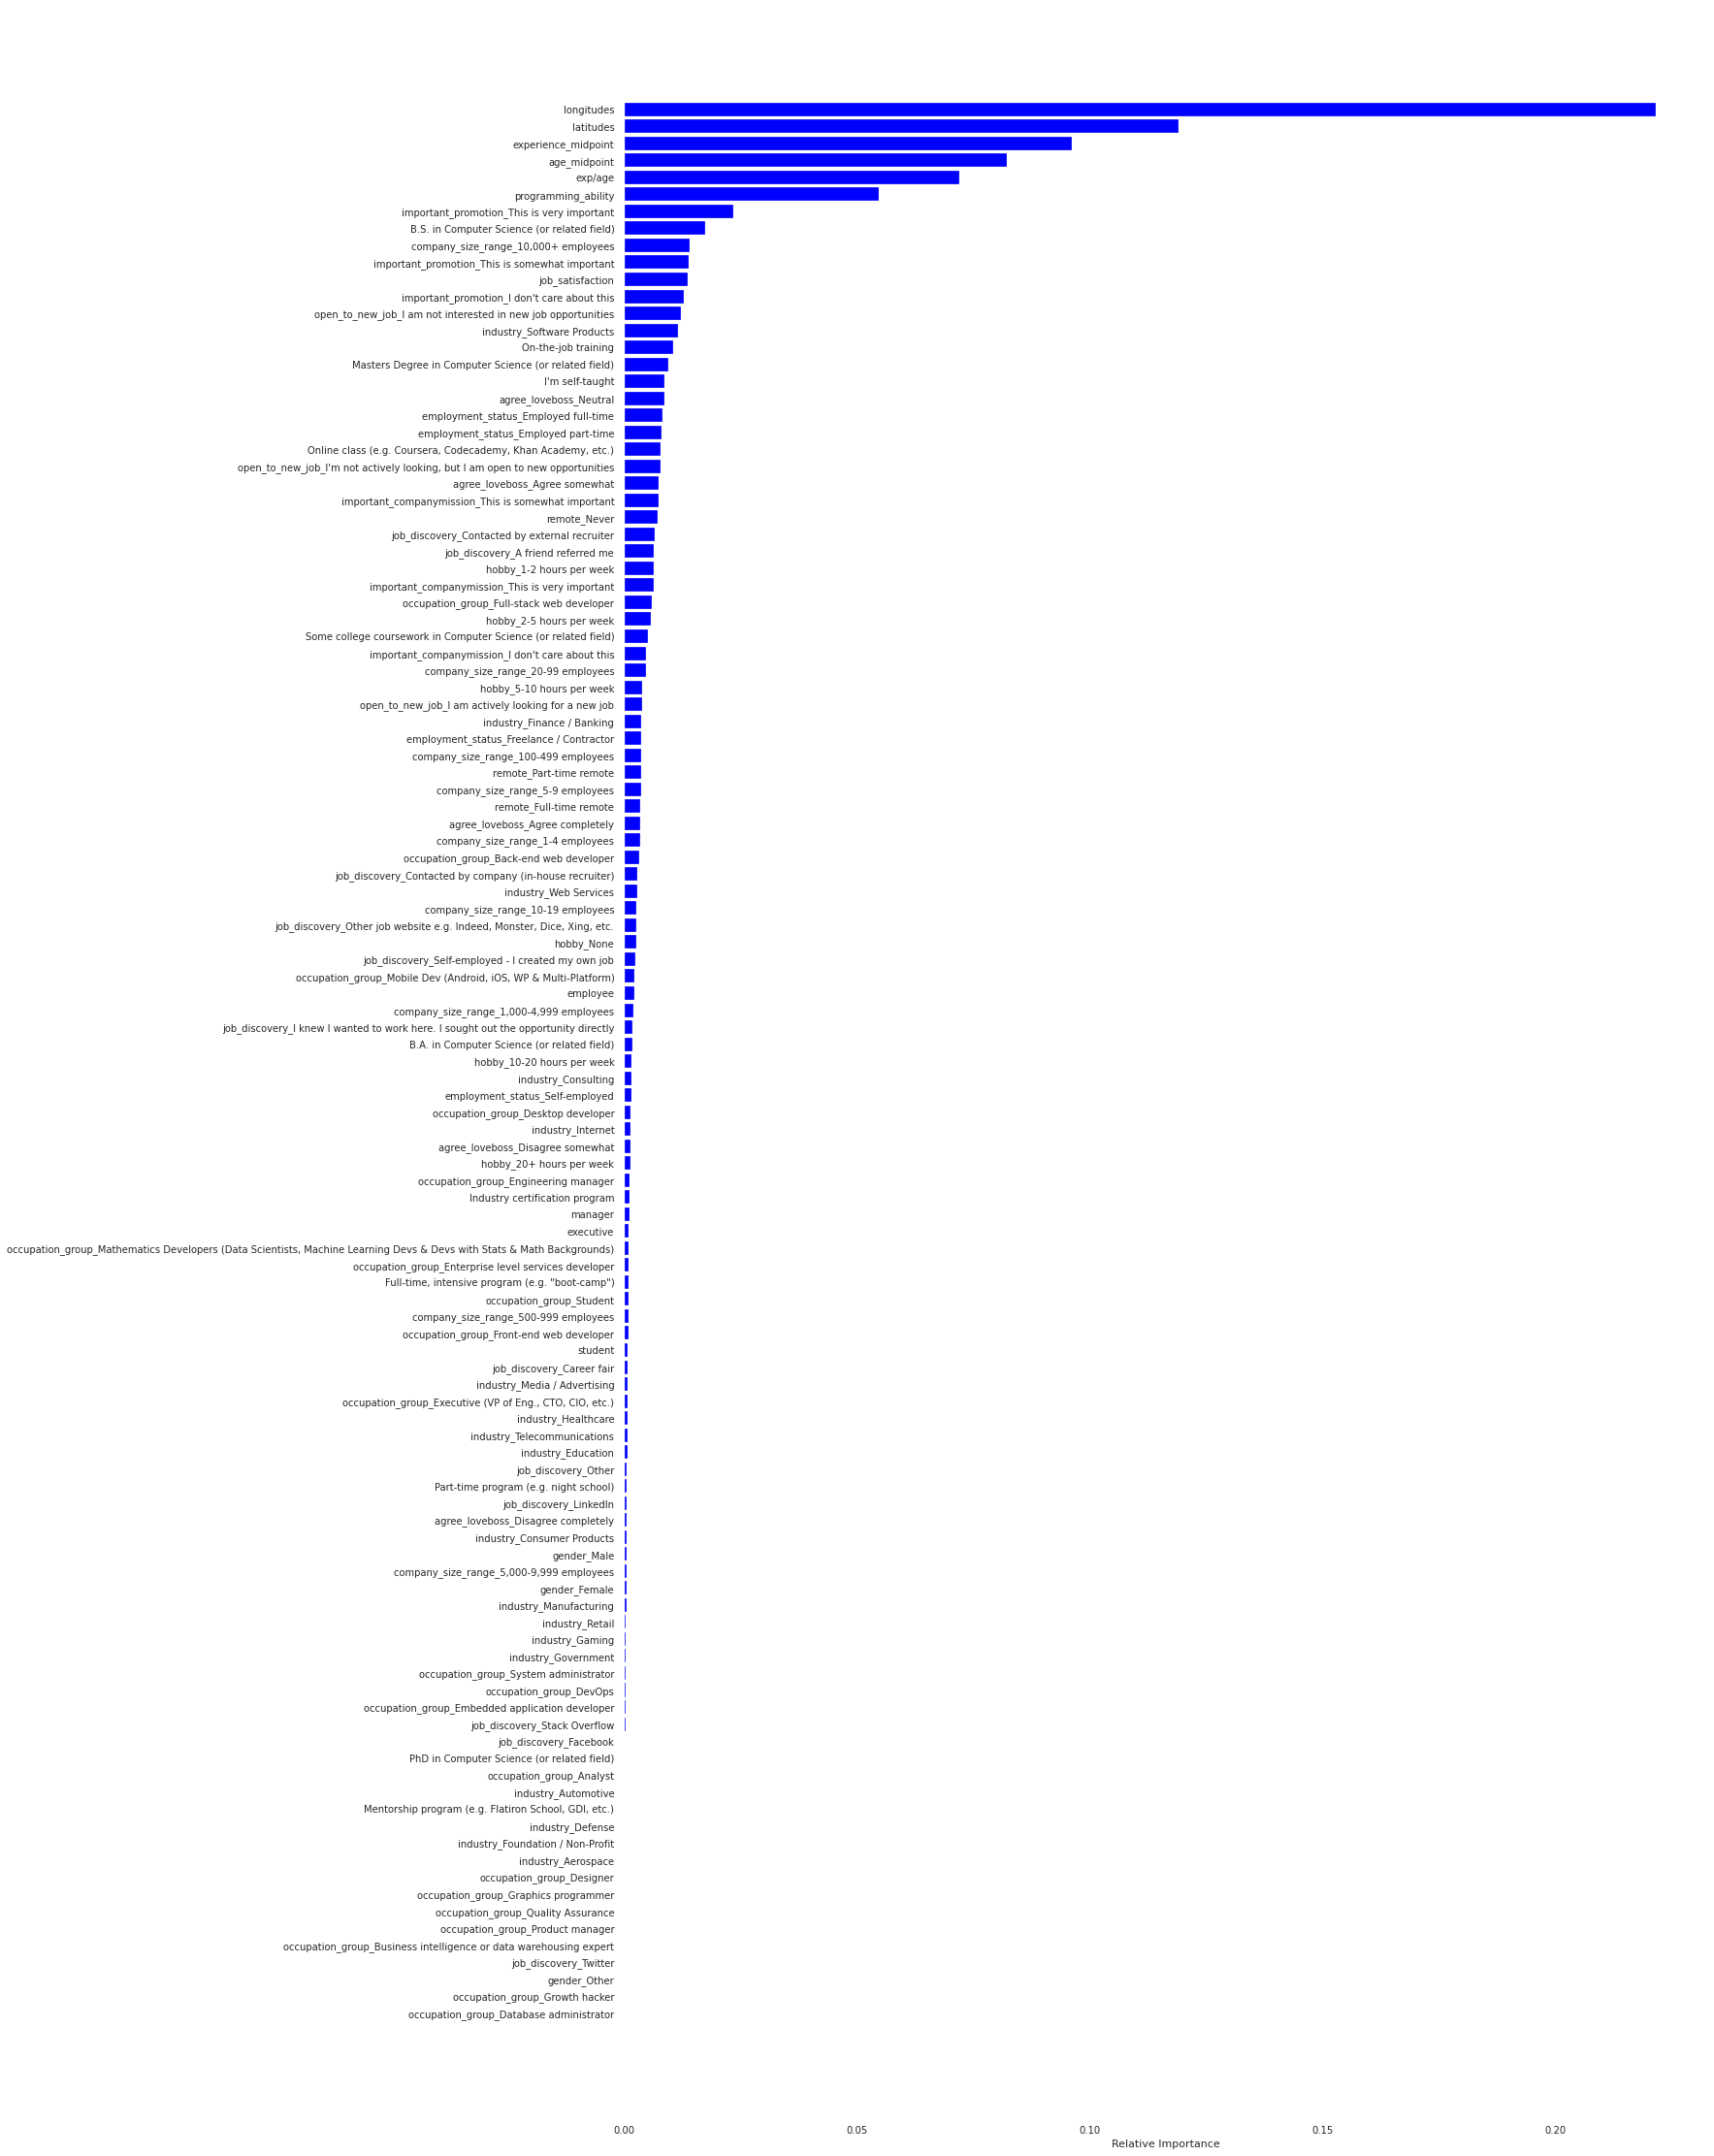

In [19]:
final_features = data_2016.drop(['country', 'education', 'salary_midpoint', 'salary_label'], axis = 1).keys()
plt.figure(figsize = (20, 40))
indices = np.argsort(feature_importances)
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [final_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Feature Selection

### Using all features

In [53]:
data_2016 = pd.read_csv('drive/MyDrive/datasets/DS salary/2016/data_2016.csv')

In [54]:
data_2016['salary_label'] = pd.cut(data_2016['salary_midpoint'],
                                   bins = [-1, 15000, 85000, np.inf],
                                   labels = [1, 2, 3])
_, num_labels = np.unique(data_2016['salary_label'], return_counts = True)
num_labels / len(data_2016)

array([0.2309949 , 0.54655612, 0.22244898])

In [55]:
def split_and_smote(data):

    from sklearn.model_selection import StratifiedShuffleSplit

    sss1 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.4, random_state = 42)

    X_all = np.array(data.drop(['country', 'education', 'salary_midpoint', 'salary_label'], axis = 1))
    salary_label = np.array(data['salary_label'])

    for train_index, cross_index in sss1.split(X_all, data['salary_label']):
        # print(train_index)
        train_set, label_train_set = X_all[train_index], salary_label[train_index]
        cross_set, label_cross_set = X_all[cross_index], salary_label[cross_index]

    sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)

    for val_index, test_index in sss2.split(cross_set, label_cross_set):
        val_set, label_val_set = cross_set[val_index], label_cross_set[val_index]
        test_set, label_test_set = cross_set[test_index], label_cross_set[test_index]

    from sklearn.preprocessing import StandardScaler
    SS = StandardScaler()

    X_train, X_val, X_test = SS.fit_transform(train_set), SS.transform(val_set), SS.transform(test_set)
    Y_train, Y_val, Y_test = label_train_set, label_val_set, label_test_set

    from imblearn.over_sampling import SMOTE

    over_sample = SMOTE(random_state = 42)
    X_smote, Y_smote = over_sample.fit_resample(X_train, Y_train)

    return X_smote, Y_smote, X_train, X_val, X_test, Y_train, Y_val, Y_test


In [56]:
X_smote, Y_smote, X_train, X_val, X_test, Y_train, Y_val, Y_test = split_and_smote(data_2016)
print(X_train.shape, X_val.shape, X_test.shape)

from sklearn.ensemble import GradientBoostingClassifier
GBC_full = GradientBoostingClassifier(learning_rate = 1, random_state = 42)
GBC_full.fit(X_smote, Y_smote)

(14112, 113) (4704, 113) (4704, 113)


GradientBoostingClassifier(learning_rate=1, random_state=42)

In [57]:
_, train_precision, _, _ = model_scores(GBC_full, X_train, Y_train)
_, val_precision, _, _ = model_scores(GBC_full, X_val, Y_val)
_, test_precision, _, _ = model_scores(GBC_full, X_test, Y_test)

precision_table = np.round(np.c_[train_precision, val_precision, test_precision], 2)
rows = np.array(['train_set', 'val_set', 'test_set']).reshape(3, 1)
precision_table = pd.DataFrame(np.hstack((rows, precision_table)), columns = ['set', 'label 1', 'label 2', 'label 3'])

### Using 1/4 features

In [44]:
final_features = data_2016.drop(['country', 'education', 'salary_midpoint', 'salary_label'], axis = 1).keys()
importances = GBC_full.feature_importances_
feature_importances = np.c_[final_features, importances]
print(len(final_features))

indices = np.argsort(importances)
drop_rate = 1/4
drop_features = final_features[indices][:int(np.round(113*drop_rate))]

113


In [45]:
copied_data = data_2016.copy()
copied_data = copied_data.drop([feature for feature in drop_features], axis = 1)
copied_data.shape

(23520, 89)

In [46]:
X_smote, Y_smote, X_train, X_val, X_test, Y_train, Y_val, Y_test = split_and_smote(copied_data)
print(X_train.shape, X_val.shape, X_test.shape)

GBC_drop = GradientBoostingClassifier(learning_rate = 1)
GBC_drop.fit(X_smote, Y_smote)

(14112, 85) (4704, 85) (4704, 85)


GradientBoostingClassifier(learning_rate=1)

In [47]:
_, train_precision, _, _ = model_scores(GBC_drop, X_train, Y_train)
_, val_precision, _, _ = model_scores(GBC_drop, X_val, Y_val)
_, test_precision, _, _ = model_scores(GBC_drop, X_test, Y_test)

precision_table = np.round(np.c_[train_precision, val_precision, test_precision], 2)
rows = np.array(['train_set', 'val_set', 'test_set']).reshape(3, 1)
precision_table = pd.DataFrame(np.hstack((rows, precision_table)), columns = ['set', 'label 1', 'label 2', 'label 3'])

# Parameteres Tuning

### all features


In [58]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'n_estimators': np.random.randint(200, 900, [10]),
                       'learning_rate': [0.005, 0.01, 0.1, 1, 2]}
random_search = RandomizedSearchCV(GBC_full, param_distributions = param_distributions, 
                                   scoring = 'f1_weighted', cv = 5, n_iter = 10)
random_search.fit(X_val, Y_val)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(learning_rate=1,
                                                        random_state=42),
                   param_distributions={'learning_rate': [0.005, 0.01, 0.1, 1,
                                                          2],
                                        'n_estimators': array([815, 505, 681, 475, 567, 523, 807, 493, 861, 392])},
                   scoring='f1_weighted')

In [59]:
best_params = random_search.best_params_
print(best_params)
learning_rate = best_params['learning_rate']
n_estimators = best_params['n_estimators']

{'n_estimators': 807, 'learning_rate': 0.1}


In [60]:
GBC_optimized = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators)
GBC_optimized.fit(X_smote, Y_smote)

GradientBoostingClassifier(n_estimators=807)

In [61]:
_, train_precision, _, f1_train = model_scores(GBC_optimized, X_train, Y_train)
_, val_precision, _, f1_val = model_scores(GBC_optimized, X_val, Y_val)
_, test_precision, _, f1_test = model_scores(GBC_optimized, X_test, Y_test)

precision_table = np.c_[train_precision, val_precision, test_precision]
f1_table = np.array([f1_train, f1_val, f1_test]).reshape(3, 1)
pre_and_f1_table = np.round(np.c_[precision_table, f1_table], 2)
rows = np.array(['train_set', 'val_set', 'test_set']).reshape(3, 1)
pre_and_f1_table = pd.DataFrame(np.hstack((rows, pre_and_f1_table)), columns = ['set', 'label 1', 'label 2', 'label 3', 'f1_score'])

In [62]:
pre_and_f1_table

,set,label 1,label 2,label 3,f1_score
0,train_set,0.87,0.78,0.78,0.86
1,val_set,0.86,0.78,0.78,0.77
2,test_set,0.85,0.74,0.74,0.77


### 1/4 features

In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'n_estimators': np.random.randint(200, 900, [10]),
                       'learning_rate': [0.005, 0.01, 0.1, 1, 2]}
random_search = RandomizedSearchCV(GBC_drop, param_distributions = param_distributions, 
                                   scoring = 'f1_weighted', cv = 5, n_iter = 10)
random_search.fit(X_val, Y_val)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(learning_rate=1),
                   param_distributions={'learning_rate': [0.005, 0.01, 0.1, 1,
                                                          2],
                                        'n_estimators': array([348, 587, 302, 614, 241, 217, 216, 555, 507, 637])},
                   scoring='f1_weighted')

In [49]:
best_params = random_search.best_params_
print(best_params)
learning_rate = best_params['learning_rate']
n_estimators = best_params['n_estimators']

{'n_estimators': 216, 'learning_rate': 0.1}


In [50]:
GBC_optimized = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators)
GBC_optimized.fit(X_smote, Y_smote)

GradientBoostingClassifier(n_estimators=216)

In [51]:
_, train_precision, _, f1_train = model_scores(GBC_optimized, X_train, Y_train)
_, val_precision, _, f1_val = model_scores(GBC_optimized, X_val, Y_val)
_, test_precision, _, f1_test = model_scores(GBC_optimized, X_test, Y_test)

precision_table = np.c_[train_precision, val_precision, test_precision]
f1_table = np.array([f1_train, f1_val, f1_test]).reshape(3, 1)
pre_and_f1_table = np.round(np.c_[precision_table, f1_table], 2)
rows = np.array(['train_set', 'val_set', 'test_set']).reshape(3, 1)
pre_and_f1_table = pd.DataFrame(np.hstack((rows, pre_and_f1_table)), columns = ['set', 'label 1', 'label 2', 'label 3', 'f1_score'])

In [52]:
pre_and_f1_table

,set,label 1,label 2,label 3,f1_score
0,train_set,0.8,0.78,0.79,0.8
1,val_set,0.8,0.77,0.78,0.77
2,test_set,0.78,0.74,0.76,0.78


# Draft

In [ ]:
small_data = data_2016[data_2016['salary_midpoint'] <= 25000]

In [ ]:
small_data['salary_label'] = pd.cut(small_data['salary_midpoint'],
                                    bins = [-1, 5000, 15000, 25000],
                                    labels = [1, 2, 3])
_, num_labels = np.unique(small_data['salary_label'], return_counts = True)
num_labels / len(small_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.35178125, 0.36242934, 0.2857894 ])

In [ ]:
X_smote_small, Y_smote_small, X_train_small, X_val_small, X_test_small, Y_train_small, Y_val_small, Y_test_small = split_and_smote(small_data)

In [ ]:
GBC_small = GradientBoostingClassifier(learning_rate = 0.1)
GBC_small.fit(X_smote_small, Y_smote_small)

GradientBoostingClassifier()

In [ ]:
val_accuracy_small, val_precision_small, val_confusing_matrix_small, val_f1_small = model_scores(GBC_small, X_val_small, Y_val_small)

In [ ]:
val_precision_small

,0,1,2
0,0.641818,0.494141,0.54902
